In [1]:
from importlib.machinery import SourceFileLoader
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
from skmob.measures.evaluation import nrmse, pearson_correlation, kullback_leibler_divergence, r_squared, rmse

In [3]:
np.random.seed(42)

In [4]:
def common_part_of_commuters(values1, values2, numerator_only=False):
    if numerator_only:
        tot = 1.0
    else:
        tot = (np.sum(values1) + np.sum(values2))
    if tot > 0:
        return 2.0 * np.sum(np.minimum(values1, values2)) / tot
    else:
        return 0.0

In [5]:
path = './utils.py'
utils = SourceFileLoader('utils', path).load_module()
path = './data_loader.py'
dgd = SourceFileLoader('dg_data', path).load_module()

db_dir = './data/boston'
dataset = 'boston'

model_dict = {}

subgroup_list = ["Under $50K", "$50K - $100K", "$100K - $200K", "Over $200K"]

for selected_subgroup_cate in subgroup_list + ["all"]:
    tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = utils.load_data(db_dir,
                                                                                                          'tile_ID',
                                                                                                          'geometry',
                                                                                                          'GEOID',
                                                                                                          'geometry',
                                                                                                          'geoid_o',
                                                                                                          'geoid_d',
                                                                                                          'pop_flows',
                                                                                                          selected_subgroup_cate,
                                                                                                         recalculate_data = 0)
    oa2features = {oa: np.concatenate((np.log([oa2pop[oa]]), feats)) for oa, feats in oa2features.items()}
    o2d2flow = {}
    for (o, d), f in od2flow.items():
        try:
            d2f = o2d2flow[o]
            d2f[d] = f
        except KeyError:
            o2d2flow[o] = {d: f}
    model_type = 'DG'
    experiment_visitors = 1
    train_data = [oa for t in pd.read_csv(db_dir + '/processed/train_tiles.csv', header=None, dtype=object)[0].values for oa
                  in tileid2oa2features2vals[str(t)].keys()]
    test_data = [oa for t in pd.read_csv(db_dir + '/processed/test_tiles.csv', header=None)[0].values for oa in
                 tileid2oa2features2vals[str(t)].keys()]
    total_data = train_data + test_data
    
    train_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': experiment_visitors}
    test_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': experiment_visitors}
    
    train_dataset = dgd.FlowDataset(train_data, **train_dataset_args)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    test_dataset = dgd.FlowDataset(test_data, **test_dataset_args)
    total_dataset = dgd.FlowDataset(total_data, **test_dataset_args)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    
    dim_input = len(train_dataset.get_features(train_data[0], train_data[2]))
    train_features = np.array([total_dataset[i][0][0] for i in range(len(total_dataset))]).reshape(len(total_dataset) * 30, dim_input)

    ss = StandardScaler()
    ss.fit(train_features)

    device = torch.device("cuda")
    model_list = []
    for round in range(1, 6):
        model = utils.load_model(f'./results/model_{model_type}_{dataset}_{selected_subgroup_cate}_round_{round}.pt', oa2centroid, oa2features, oa2pop, dim_s=dim_input, device=device)
        model_list.append(model)
        
    model_dict[selected_subgroup_cate] = {
        "test_dataset": test_dataset,
        "ss": ss,
        "model": model_list
    }

./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In

In [6]:
values = list(oa2pop.values())
quantiles = np.quantile(values, np.linspace(0, 1, 11))

quantile_dict = {key: np.digitize(value, quantiles) for key, value in oa2pop.items()}

In [10]:
from scipy import stats
from scipy.spatial import distance

all_test_loader = torch.utils.data.DataLoader(model_dict["all"]["test_dataset"], batch_size=1)

res_log_list = []
cpc_by_quantile = dict(zip(range(1, 11), [[] for _ in range(10)]))

for round_idx in range(5):
    cpc_list = []
    target_flow_list = []
    predicted_flow_list = []
    
    for batch_idx, all_data_temp in enumerate(all_test_loader):
        all_b_data = all_data_temp[0]
        all_b_target = all_data_temp[1]
        geoid = all_data_temp[2][0][0]
        quantile = quantile_dict[geoid]
    
        for sample_idx in range(len(all_b_data)):
            sample_target = all_b_target[sample_idx]
            if sample_target.sum() == 0:
                continue
    
            agg_target = []
            agg_output = []
            for subgroup in subgroup_list:
                subgroup_data_temp = model_dict[subgroup]["test_dataset"].__getitem__(batch_idx)
                subgroup_ss = model_dict[subgroup]["ss"]
                subgroup_model = model_dict[subgroup]["model"][round_idx]
                
                subgroup_data = subgroup_data_temp[0][sample_idx]
                subgroup_target = subgroup_data_temp[1][sample_idx]
    
                subgroup_data = torch.tensor([subgroup_ss.transform(subgroup_data)]).float()
    
                output = subgroup_model.forward(subgroup_data)
                subgroup_test_model = subgroup_model.get_flatten_test_model(subgroup_data, subgroup_target)
    
                agg_target.append(subgroup_target)
                agg_output.append(subgroup_test_model)
    
            cpc = common_part_of_commuters(sum(agg_target).numpy(), sum(agg_output))
            cpc_by_quantile[quantile].append(cpc)
            cpc_list.append(cpc)
            target_flow_list.extend(sum(agg_target).tolist())
            predicted_flow_list.extend(sum(agg_output).tolist())

    cpc_mean = np.mean(cpc_list)
    corr = stats.pearsonr(target_flow_list, predicted_flow_list)[0]
    jsd = distance.jensenshannon(target_flow_list, predicted_flow_list)
    rmse_val = rmse(target_flow_list, predicted_flow_list)
    nrmse_val = rmse(target_flow_list, predicted_flow_list) / (max(target_flow_list) - min(target_flow_list))
    
    res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    print("social groups + visitors CPC", np.mean(cpc_list), np.std(cpc_list))
    print("social groups + visitors Corr", stats.pearsonr(target_flow_list, predicted_flow_list))
    print("social groups + visitors JSD", distance.jensenshannon(target_flow_list, predicted_flow_list))
    print("social groups + visitors RMSE", rmse(target_flow_list, predicted_flow_list))

social groups + visitors CPC 0.694183951728031 0.06806940110361497
social groups + visitors Corr PearsonRResult(statistic=0.5969209132894461, pvalue=0.0)
social groups + visitors JSD 0.27833159419758896
social groups + visitors RMSE 61.204743624501276
social groups + visitors CPC 0.6910258378190136 0.06936613023716215
social groups + visitors Corr PearsonRResult(statistic=0.5923414034440202, pvalue=0.0)
social groups + visitors JSD 0.2818929722945794
social groups + visitors RMSE 61.47213785543218
social groups + visitors CPC 0.6917242599397468 0.06812940654985104
social groups + visitors Corr PearsonRResult(statistic=0.5906969836695778, pvalue=0.0)
social groups + visitors JSD 0.28058080261283624
social groups + visitors RMSE 61.68877973951272
social groups + visitors CPC 0.6899238480589097 0.06858523337566504
social groups + visitors Corr PearsonRResult(statistic=0.5794862774687278, pvalue=0.0)
social groups + visitors JSD 0.2822390306873126
social groups + visitors RMSE 62.204963623

In [11]:
pd.DataFrame(res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.690912,0.587248,0.281457,61.773707,0.023469
std,0.002380,0.008674,0.002185,0.469747,0.000178
min,0.687702,0.576794,0.278332,61.204744,0.023253
25%,0.689924,0.579486,0.280581,61.472138,0.023355
50%,0.691026,0.590697,0.281893,61.688780,0.023437
75%,0.691724,0.592341,0.282239,62.204964,0.023633
max,0.694184,0.596921,0.284242,62.297912,0.023669


In [14]:
all_ss = model_dict["all"]["ss"]
all_res_log_list = []

for round_idx in range(5):
    all_cpc_list = []
    all_target_flow_list = []
    all_predicted_flow_list = []
    for batch_idx, data_temp in enumerate(all_test_loader):
        b_data = data_temp[0]
        b_target = data_temp[1]
        ids = data_temp[2]
    
        all_model = model_dict["all"]["model"][round_idx]
        for data, target in zip(b_data, b_target):
            if target.sum() == 0:
                continue
            data = torch.tensor([all_ss.transform(data[0])]).float()
            output = all_model.get_flatten_test_model(data, target)
            cpc = common_part_of_commuters(sum(target).numpy(), output)
            all_cpc_list.append(cpc)
            all_target_flow_list.extend(sum(target).tolist())
            all_predicted_flow_list.extend(output.tolist())

    cpc_mean = np.mean(all_cpc_list)
    corr = stats.pearsonr(all_target_flow_list, all_predicted_flow_list)[0]
    jsd = distance.jensenshannon(all_target_flow_list, all_predicted_flow_list)
    rmse_val = rmse(all_target_flow_list, all_predicted_flow_list)
    nrmse_val = rmse(all_target_flow_list, all_predicted_flow_list) / (max(all_target_flow_list) - min(all_target_flow_list))

    all_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    print("No social groups + visitors CPC", np.mean(all_cpc_list), np.std(all_cpc_list))
    print("No social groups + visitors Corr", stats.pearsonr(all_target_flow_list, all_predicted_flow_list))
    print("No social groups + visitors JSD", distance.jensenshannon(all_target_flow_list, all_predicted_flow_list))

No social groups + visitors CPC 0.6788509681987703 0.06833286385385887
No social groups + visitors Corr PearsonRResult(statistic=0.5636571225557858, pvalue=0.0)
No social groups + visitors JSD 0.2901449459550303
No social groups + visitors CPC 0.6767340403840651 0.07077040896182009
No social groups + visitors Corr PearsonRResult(statistic=0.5603344085812447, pvalue=0.0)
No social groups + visitors JSD 0.29250154625319985
No social groups + visitors CPC 0.6773597684698454 0.0699553312253304
No social groups + visitors Corr PearsonRResult(statistic=0.5568311301453562, pvalue=0.0)
No social groups + visitors JSD 0.2924104346657914
No social groups + visitors CPC 0.6801937992743171 0.06652582680073622
No social groups + visitors Corr PearsonRResult(statistic=0.5696327468905434, pvalue=0.0)
No social groups + visitors JSD 0.28844040610237287
No social groups + visitors CPC 0.6778496418653704 0.06918400888875002
No social groups + visitors Corr PearsonRResult(statistic=0.562537825327458, pva

In [15]:
pd.DataFrame(all_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.678198,0.562599,0.290985,65.556590,0.024128
std,0.001358,0.004717,0.001711,0.551200,0.000203
min,0.676734,0.556831,0.288440,65.072735,0.023950
25%,0.677360,0.560334,0.290145,65.193863,0.023995
50%,0.677850,0.562538,0.291426,65.395521,0.024069
75%,0.678851,0.563657,0.292410,65.662943,0.024167
max,0.680194,0.569633,0.292502,66.457890,0.024460


In [16]:
path = './utils.py'
utils = SourceFileLoader('utils', path).load_module()
path = './data_loader.py'
dgd = SourceFileLoader('dg_data', path).load_module()

db_dir = './data/boston'
dataset = 'boston'

device = torch.device("cuda")

no_visitor_model_dict = {}
subgroup_list = ["Under $50K", "$50K - $100K", "$100K - $200K", "Over $200K"]

for selected_subgroup_cate in subgroup_list + ["all"]:
    tileid2oa2features2vals, oa_gdf, flow_df, oa2pop, oa2features, od2flow, oa2centroid = utils.load_data(db_dir,
                                                                                                          'tile_ID',
                                                                                                          'geometry',
                                                                                                          'GEOID',
                                                                                                          'geometry',
                                                                                                          'geoid_o',
                                                                                                          'geoid_d',
                                                                                                          'pop_flows',
                                                                                                          selected_subgroup_cate,
                                                                                                         recalculate_data = 0)
    oa2features = {oa: np.concatenate((np.log([oa2pop[oa]]), feats)) for oa, feats in oa2features.items()}
    o2d2flow = {}
    for (o, d), f in od2flow.items():
        try:
            d2f = o2d2flow[o]
            d2f[d] = f
        except KeyError:
            o2d2flow[o] = {d: f}
    model_type = 'DG'
    experiment_visitors = 0
    train_data1 = [oa for t in pd.read_csv(db_dir + '/processed/train_tiles.csv', header=None, dtype=object)[0].values for oa
                  in tileid2oa2features2vals[str(t)].keys()]
    test_data = [oa for t in pd.read_csv(db_dir + '/processed/test_tiles.csv', header=None)[0].values for oa in
                 tileid2oa2features2vals[str(t)].keys()]
    total_data = train_data + test_data
    
    train_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': 0}
    test_dataset_args = {'tileid2oa2features2vals': tileid2oa2features2vals,
                          'o2d2flow': o2d2flow,
                          'oa2features': oa2features,
                          'oa2pop': oa2pop,
                          'oa2centroid': oa2centroid,
                          'dim_dests': 30,
                          'frac_true_dest': 1,
                          'model': model_type,
                          'experiment_visitors': 0}
    
    train_dataset = dgd.FlowDataset(train_data, **train_dataset_args)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
    test_dataset = dgd.FlowDataset(test_data, **test_dataset_args)
    total_dataset = dgd.FlowDataset(total_data, **test_dataset_args)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
    
    dim_input = len(train_dataset.get_features(train_data[0], train_data[2]))
    train_features = np.array([total_dataset[i][0][0] for i in range(len(total_dataset))]).reshape(len(total_dataset) * 30, dim_input)

    ss = StandardScaler()
    ss.fit(train_features)
    model_list = []
    for round in range(1, 6):
        model = utils.load_model(f'./results/model_{model_type}_{dataset}_{selected_subgroup_cate}_round_{round}_no_visitors.pt', oa2centroid, oa2features, oa2pop, dim_s=dim_input, device=device)
        model_list.append(model)
        
    no_visitor_model_dict[selected_subgroup_cate] = {
        "test_dataset": test_dataset,
        "ss": ss,
        "model": model_list
    }

./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  oa_pop = flow_df.groupby('residence').sum()
./utils.py:180: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In

In [22]:
from scipy import stats
from scipy.spatial import distance

all_test_loader = torch.utils.data.DataLoader(no_visitor_model_dict["all"]["test_dataset"], batch_size=1)
no_visitor_res_log_list = []

for round_idx in range(5):
    no_visitor_cpc_list = []
    no_visitor_target_flow_list = []
    no_visitor_predicted_flow_list = []
    for batch_idx, all_data_temp in enumerate(all_test_loader):
        all_b_data = all_data_temp[0]
        all_b_target = all_data_temp[1]
    
        for sample_idx in range(len(all_b_data)):
            sample_target = all_b_target[sample_idx]
            if sample_target.sum() == 0:
                continue
    
            agg_target = []
            agg_output = []
            for subgroup in subgroup_list:
                subgroup_data_temp = no_visitor_model_dict[subgroup]["test_dataset"].__getitem__(batch_idx)
                subgroup_ss = no_visitor_model_dict[subgroup]["ss"]
                subgroup_model = no_visitor_model_dict[subgroup]["model"][round_idx]
                
                subgroup_data = subgroup_data_temp[0][sample_idx]
                subgroup_target = subgroup_data_temp[1][sample_idx]
    
                subgroup_data = torch.tensor([subgroup_ss.transform(subgroup_data)]).float()
    
                output = subgroup_model.forward(subgroup_data)
                subgroup_test_model = subgroup_model.get_flatten_test_model(subgroup_data, subgroup_target)
    
                agg_target.append(subgroup_target)
                agg_output.append(subgroup_test_model)
    
            cpc = common_part_of_commuters(sum(agg_target).numpy(), sum(agg_output))
            no_visitor_cpc_list.append(cpc)
            no_visitor_target_flow_list.extend(sum(agg_target).tolist())
            no_visitor_predicted_flow_list.extend(sum(agg_output).tolist())

    cpc_mean = np.mean(no_visitor_cpc_list)
    corr = stats.pearsonr(no_visitor_target_flow_list, no_visitor_predicted_flow_list)[0]
    jsd = distance.jensenshannon(no_visitor_target_flow_list, no_visitor_predicted_flow_list)
    rmse_val = rmse(no_visitor_target_flow_list, no_visitor_predicted_flow_list)
    nrmse_val = rmse(no_visitor_target_flow_list, no_visitor_predicted_flow_list) / (max(no_visitor_target_flow_list) - min(no_visitor_target_flow_list))

    no_visitor_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    
    print("social groups + No visitors CPC", np.mean(no_visitor_cpc_list), np.std(no_visitor_cpc_list))
    print("social groups + No visitors Corr", stats.pearsonr(no_visitor_target_flow_list, no_visitor_predicted_flow_list))
    print("social groups + No visitors JSD", distance.jensenshannon(no_visitor_target_flow_list, no_visitor_predicted_flow_list))

social groups + No visitors CPC 0.6854995327512067 0.06967880284184437
social groups + No visitors Corr PearsonRResult(statistic=0.548356162147864, pvalue=0.0)
social groups + No visitors JSD 0.28806328949999555
social groups + No visitors CPC 0.6839577261318832 0.07014683261229614
social groups + No visitors Corr PearsonRResult(statistic=0.5415014045965445, pvalue=0.0)
social groups + No visitors JSD 0.28954311149432466
social groups + No visitors CPC 0.6817394788608989 0.06868797450806363
social groups + No visitors Corr PearsonRResult(statistic=0.5518960550907125, pvalue=0.0)
social groups + No visitors JSD 0.2906398499753425
social groups + No visitors CPC 0.6832645562852534 0.06958945307327544
social groups + No visitors Corr PearsonRResult(statistic=0.5538648045534593, pvalue=0.0)
social groups + No visitors JSD 0.2896330176577082
social groups + No visitors CPC 0.6808494285561707 0.07037407523170393
social groups + No visitors Corr PearsonRResult(statistic=0.5391207488533288, pv

In [23]:
pd.DataFrame(no_visitor_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.683062,0.546948,0.289924,64.296950,0.024428
std,0.001832,0.006427,0.001369,0.501930,0.000191
min,0.680849,0.539121,0.288063,63.892793,0.024275
25%,0.681739,0.541501,0.289543,63.992056,0.024312
50%,0.683265,0.548356,0.289633,64.000491,0.024315
75%,0.683958,0.551896,0.290640,64.518620,0.024512
max,0.685500,0.553865,0.291739,65.080791,0.024726


In [19]:
no_visitors_all_ss = no_visitor_model_dict["all"]["ss"]
no_visitors_all_res_log_list = []
no_visitors_all_cpc_by_quantile = dict(zip(range(1, 11), [[] for _ in range(10)]))

for round_idx in range(5):
    no_visitors_all_cpc_list = []
    no_visitors_all_target_flow_list = []
    no_visitors_all_predicted_flow_list = []
    for batch_idx, data_temp in enumerate(all_test_loader):
        b_data = data_temp[0]
        b_target = data_temp[1]
        geoid = data_temp[2][0][0]
        quantile = quantile_dict[geoid]
    
        all_model = no_visitor_model_dict["all"]["model"][round_idx]
        for data, target in zip(b_data, b_target):
            if target.sum() == 0:
                continue
            data = torch.tensor([no_visitors_all_ss.transform(data[0])]).float()
            output = all_model.get_flatten_test_model(data, target)
            cpc = all_model.get_cpc(data, target)
            no_visitors_all_cpc_by_quantile[quantile].append(cpc)
            no_visitors_all_cpc_list.append(cpc)
            no_visitors_all_target_flow_list.extend(sum(target).tolist())
            no_visitors_all_predicted_flow_list.extend(output.tolist())

    cpc_mean = np.mean(no_visitors_all_cpc_list)
    corr = stats.pearsonr(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)[0]
    jsd = distance.jensenshannon(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)
    rmse_val = rmse(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list)
    nrmse_val = rmse(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list) / (max(no_visitors_all_target_flow_list) - min(no_visitors_all_target_flow_list))

    no_visitors_all_res_log_list.append((cpc_mean, corr, jsd, rmse_val, nrmse_val))
    
    print("No social groups + No visitors CPC", np.mean(no_visitors_all_cpc_list), np.std(no_visitors_all_cpc_list))
    print("No social groups + No visitors Corr", stats.pearsonr(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list))
    print("No social groups + No visitors JSD", distance.jensenshannon(no_visitors_all_target_flow_list, no_visitors_all_predicted_flow_list))
# 246.7232625702422 0.6326237501801082 0.3157671742374284 390

No social groups + No visitors CPC 0.6801308410178217 0.06940662357136586
No social groups + No visitors Corr PearsonRResult(statistic=0.5450537355294898, pvalue=0.0)
No social groups + No visitors JSD 0.294671075984413
No social groups + No visitors CPC 0.6844017048879272 0.06928723927902376
No social groups + No visitors Corr PearsonRResult(statistic=0.537912693446584, pvalue=0.0)
No social groups + No visitors JSD 0.2908092478136378
No social groups + No visitors CPC 0.6817888110477623 0.06938505028306662
No social groups + No visitors Corr PearsonRResult(statistic=0.5465901699677813, pvalue=0.0)
No social groups + No visitors JSD 0.2931595111191723
No social groups + No visitors CPC 0.6771236706068642 0.07017967560917893
No social groups + No visitors Corr PearsonRResult(statistic=0.5422848158029, pvalue=0.0)
No social groups + No visitors JSD 0.2967866283355567
No social groups + No visitors CPC 0.6820058943968195 0.06791396814885163
No social groups + No visitors Corr PearsonRRes

In [20]:
pd.DataFrame(no_visitors_all_res_log_list).describe()

,0,1,2,3,4
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.681090,0.542586,0.293694,67.095466,0.024695
std,0.002690,0.003402,0.002211,0.402013,0.000148
min,0.677124,0.537913,0.290809,66.756180,0.024570
25%,0.680131,0.541088,0.293042,66.766338,0.024574
50%,0.681789,0.542285,0.293160,66.892789,0.024620
75%,0.682006,0.545054,0.294671,67.495398,0.024842
max,0.684402,0.546590,0.296787,67.566628,0.024868


In [98]:
np.array([res_log_list, all_res_log_list, no_visitor_res_log_list, no_visitors_all_res_log_list]).mean(axis=1)

array([[ 0.69088676,  0.58739079,  0.28149483, 61.76725718],
       [ 0.67811836,  0.56291816,  0.29103236, 65.54231907],
       [ 0.6828723 ,  0.54663126,  0.29010172, 64.31412627],
       [ 0.68085644,  0.54216035,  0.29384522, 67.12224296]])

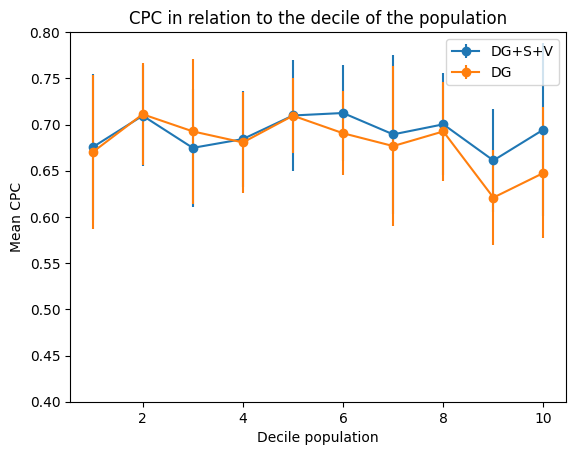

In [109]:
import matplotlib.pyplot as plt

def plot_error_bars(data, label):
    keys = data.keys()
    means = [np.mean(values) for values in data.values()]
    stds = [np.std(values) for values in data.values()]
    plt.errorbar(keys, means, yerr=stds, fmt='-o', capsize=0, label=label)

# Plotting
plot_error_bars(cpc_by_quantile, 'DG+S+V')
plot_error_bars(no_visitors_all_cpc_by_quantile, 'DG')

plt.xlabel('Decile population')
plt.ylabel('Mean CPC')
plt.ylim(0.4, 0.8)  # Adjusted to ensure y-axis starts from 0
plt.title('CPC in relation to the decile of the population')
plt.legend()
plt.show()

Text(0, 0.5, 'Relative Improvement (%)')

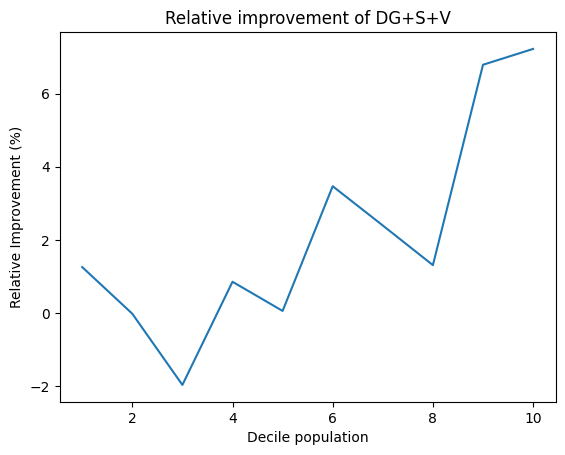

In [115]:
plt.plot(cpc_by_quantile.keys(), [((np.array(cpc_by_quantile[q]) - np.array(no_visitors_all_cpc_by_quantile[q])) / np.array(no_visitors_all_cpc_by_quantile[q]) * 100).mean() for q in range(1, 11)])
plt.title('Relative improvement of DG+S+V')
plt.xlabel('Decile population')
plt.ylabel('Relative Improvement (%)')